<a href="https://colab.research.google.com/github/jkjh23/BusanAIDeveloperCourse_AI/blob/master/3_DeepLearning/13-2_%EA%B0%95%ED%99%94%ED%95%99%EC%8A%B5_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 강화학습 실습

## 다중 슬롯 머신

- 알고리즘, 가치계산용
  - UCB1
  - 엡실론-greedy (ε- greedy) 

## 미로 게임

- 정책 계산 방법 알고리즘 활용
  - 정책 경사법
  - Sarsa
  - Q-Learning

## 카트-풀 게임

- 정책 계산 방법
  - DQN

# 다중 슬롯 머신

- 목적
  - 강화학습의 스타일을 익힌다
  - 강화학습의 요소들을 적재적소에 배치하여 학습 스타일을 익힌다
- 환경
  - 게임의 룰
  - 슬롯머신의 ARM(팔)이 여러 개 존재할 수 있다(다중 슬롯 머신)
  - 각 Arm을 선택할때, 보상(reward)이 다르고, 각각 확률이 정해져 있다. 모니터  X
    - 1번 arm 10%
    - 2번 arm 50%
    - 3번 arm 100% 
    - 이렇게 각각의 확률로 보상을 똑같이 1.0을 받는다
  - 에이전트는 게임을 시작하면, 각 팔에 대한 확률을 모른다 -> 게임이 세팅되면 보상 확률이 설정된다
    - 보상의 크기는 상관없고, 보상을 받는가/못 받는가만 신경쓴다
- 목적
  - 에이전트는 보상을 가장 많이 받을 수 있는 arm을 집중적으로 선택할 수 있게 학습시키는 것 목적
  - 제한된 횟수에서 최대 보상을 받는 것
  - 어떤 순서로 arm을 선택해야 하는가?
  - 어떤 arm을 가장 많이 당겨야 가장 큰 보상을 얻는가?

- 에이전트 행동
  - 여러개의 슬롯 중 한개의 arm을 선택
  - 선택한 arm을 당기면 -> 행동 -> 1 에피소드 완료/종료
  - 상태 변화 없다

|강화 학습 요소|다중 슬롯 머신의 내용|
|:--:|:--:|
|에이전트|슬롯 머신을 내리는 사람|
|환경|다중 슬롯 머신|
|목적|많은 보상 획득, 단 제한된 횟수|
|행동|여러개의 Arm중 한개를 선택|
|에피소드|Arm을 당기면 종료.1회의 행동|
|상태|없음|
|보상|모두 동일. 1.0|
|수익|보상의 총합(즉시보상+지연보상:없음)|
|학습방법|UCB1, ε- greedy|
|파라미터 변경 주기(정책 결정하는 측면)|1회의 행동 종료후|
|정책|다음 칸에 고려사항 기술|

## 정책에 대한 정리

- Arm을 제한된 횟수 내에서 선택할수 있다
  - 10회, 100회, 1000회 등
- 탐색
  - 어떤 Arm을 당겨야 어떤 확률로 보상을 받는지 모른다. 최초의 전략은 랜덤하게 선택
- 이용
  - 정보 수집을 수행한 후(한개씩 다 당겨본다), 이 정보를 기반으로 보상이 가장 높다고 판단되는 Arm을 선택
- 문제점
  - 탐색과 이용의 트레이드 오프 상황
  - 정보수집을 위해서 탐색만 수행하면, 언젠가 모든 Arm에 대한 보상 정보를 알게 되지만, 제한된 횟수라는 환경 안에서 보상이 가장 높은 팔만 당기는 것보다 수익이 적을 수 있다
  - 반대 관점에서 보면, 현 시점에서 가장 보상이 높은 Arm만 선택하면, 더 많은 보상을 지급하는 팔을 선택하지 못하는 문제도 발생
  - 트레이드 오프 문제의 결론은 균형이다



```
구조
- SlotMachineGame
  L SlotArm Class                   : 게임 판(환경)
  L GameEngine Class                : 게임 엔진의 표준 인터페이스 제공
    L EpsilonGreedyEngine Class     : 엡실론 알고리즘 적용
    L UCB1Engine Class              : UCB1 알고리즘 적용
  L GameSimulator Class or Function : 게임가동
```



In [ ]:
# 1. 필요 모듈
import numpy as np
import random
import math
# 학습 결과를 시각화하기 위해 사용
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# SlotArm

In [ ]:
a = [ random.random() for n in range(100) ]
np.min(a), np.max(a)
# 0.0 ~ 1.0 => 랜덤하게 확률값을 추출한다

(0.014472064783029315, 0.9852963446037278)

In [ ]:
# 다중 슬롯 머신 -> 슬롯 머신에 Arm이 n개 생성된다
# Arm은 보상을 주는 확률을 고유하게 각각 가지고 있다
# 게임 환경
class SlotArm():
  # 생성자
  # p : 고유한 SlotArm 객체가 가지는 보상 지급 확률
  def __init__(self, p):
    self.p = p
    pass
  # 보상 처리
  # random.random() : 0.0 ~ 1.0 => 퍼센트
  # Arm을 만들 때 세팅된 초기값 p보다 작은 범위에 난수값이 들어올 때 보상을 제공하겠다
  def reward( self):
    # random.random() => 이 난수는 표준편차? => 0.0 ~ 1.0이 나오는 빈도가 균등해야 한다
    if self.p > random.random():    # 난수값이 설정한 확률보다 작으면
      return 1.0
    else:
      return 0.0
    pass


# GameEngine

In [ ]:
class GameEngine():
  # 생성자                    : 생략가능 -> 멤버변수 초기화
  # 알고리즘, 게임환경 초기화 : initalize
  def initalize(self):      pass
  # 팔을 당긴다               : pull_arm
  def pull_arm(self):       pass
  # 보상 업데이트             : update_value
  def update_value(self):   pass
  # 설명                      : get_algo_name
  def get_algo_name(self):  pass  

# EpsilonGreedyEngine

- ε-greedy 알고리즘
  - 확률 ε(0~1)으로 랜덤하게 행동을 선택한다
    - 에이전트가 취하는 행동은 Arm을 선택하는 행위
  - ε값으로 통상 0.1을 사용하는 경우, 가장 보상을 높게 주는 팔을 선택할 확률이 높다(가장 좋은 성능을 낸다)
  - ε-greedy 알고리즘 도입 이유는 탐색과 이용이라는 상반된 2개 개념을 어떤 비중으로 배치할것인가?
    - 탐색 : ε으로 배치
    - 이용 : 1-ε으로 배치

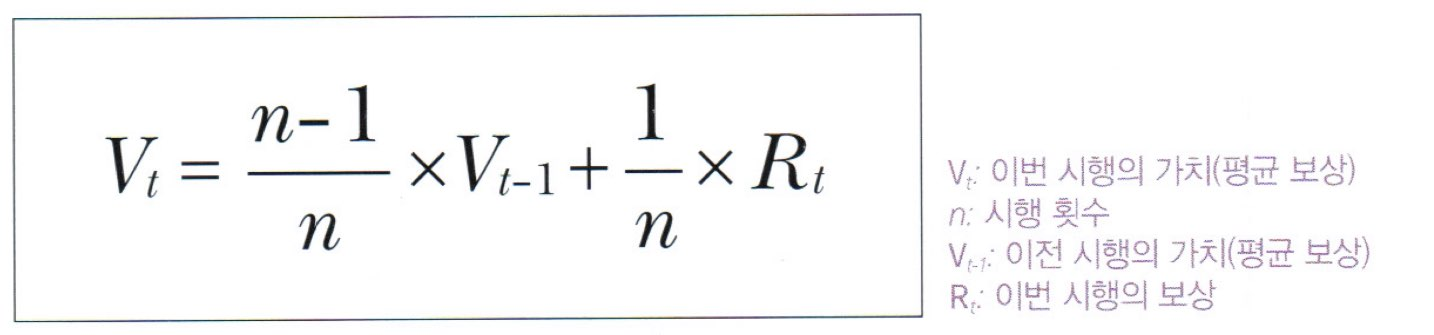

In [ ]:
from IPython.display import Image
Image('/content/drive/My Drive/2020_AI_Busan/4_DeepLearning/pic_rl/ε-greedy.jpeg')

# ε-greedy를 이용하여 가치를 계산할때 사용하는 식
# n는 팔 한 개에 전체(빈도) 시행 횟수, 가치는 각각 팔별로 계산한다 -> 팔별로 가치가 높은 팔을 선택(이용의 기준)
# 현재 시점의 행동의 가치(평균 보상) = (처음부터 지금 직전까지 시도) * 이전 행동 후 얻은 가치 + (지금 시행한 시도) * 이번 행동 후 얻는 보상(가치)

In [ ]:
class EpsilonGreedyEngine(GameEngine):
  # 생성자에서 앱실론 초기값을 부여하겠다
  # 0.1은 통상 앱실론에서 가장 좋은 성능을 냈던 값
  def __init__(self, epsilon=0.1):
    self.epsilon = epsilon # 탐색을 하는 확률값

  # 초기화
  # 각 팔을 선택한 횟수 -> 선택하지 않은 팔을 구분할 수 있다, 집중적으로 사용하고 있는 팔도 기억할수 있다 
  # 각 팔별로 사용한 횟수만 기억 -> 팔의 개수대로 리스트를 생성 혹은 배열 혹은 텐서
  # 팔의 개수는 게임이 생성되면(게임엔진이 생성) 세팅하겠다(매번 다를수 있다)
  def initalize(self, cnt_arms ):
    # 배열로 각 팔의 사용빈도를 기록
    self.n = np.zeros( cnt_arms )
    # 각 팔을 선택함으로써 얻은 보상을 기록 -> 각 팔의 가치
    self.v = np.zeros( cnt_arms )
    pass  
  # Arm을 선택
  def pull_arm(self):  
    # 팔의 선택 기준은 아래 2개 중에 하나이다
    # 탐색
    # self.epsilon이 0.1이므로, 탐색은 모든 행동에서 10%만 수행하겠다
    if self.epsilon > random.random():
      # 랜덤하게 팔을 선택해서 탐색한다 -> 랜덤값의 범위는 0 <= x < 팔의 개수, 정수 : 인덱스니까
      return np.random.randint( 0, len(self.n) )
    # 이용 => 1-0.1 => 90%는 집중 공략(이미 탐색한 팔들 중에서 가치가 가장 높은 팔을 집중)
    else:
      # 90% 확률로 가장 높은 보상을 받은 팔을 선택한다 -> 분류
      return np.argmax( self.v )
    pass  
  # 선택한 팔에 대한 가치를 갱신
  # choice_arm : 선택한 팔의 번호 -> 몇번째 슬롯머신의 arm을 선택했는지 번호
  # reward는 1.0 일수도 있고, 0.0일수도 있다
  def update_value(self, choice_arm, reward):   
    # 1. 선택한 팔에 대한 카운트 증가
    self.n[ choice_arm ] += 1
    # 2. 이번 행동에 대한 가치 갱신 -> 해당 팔에 대한 가치 갱신 
    n = self.n[ choice_arm ]
    v = self.v[ choice_arm ]
    # 가치 갱신을 1.0 혹은 0.0을 그냥 더하는게 아니라, 앱실론 그리드 알고리즘을 사용하므로 가치 계산법 식을 사용한다
    self.v[ choice_arm ] = ( (n-1)/n )*v + (1/n)*reward    
  def get_algo_name(self):  
    return 'ε-greedy 알고리즘'

# UCB1Engine

- 원리
  - 모든 팔을 한번 이상 사용할 때까지는, 가치 갱신을 하지 않는다 => 탐색 진행
  - 만약, 모든 팔을 1회이상 사용해봤다면, arm에 대한 가치 갱신을 시도한다
  - 가치 생신 식은 아래와 같다

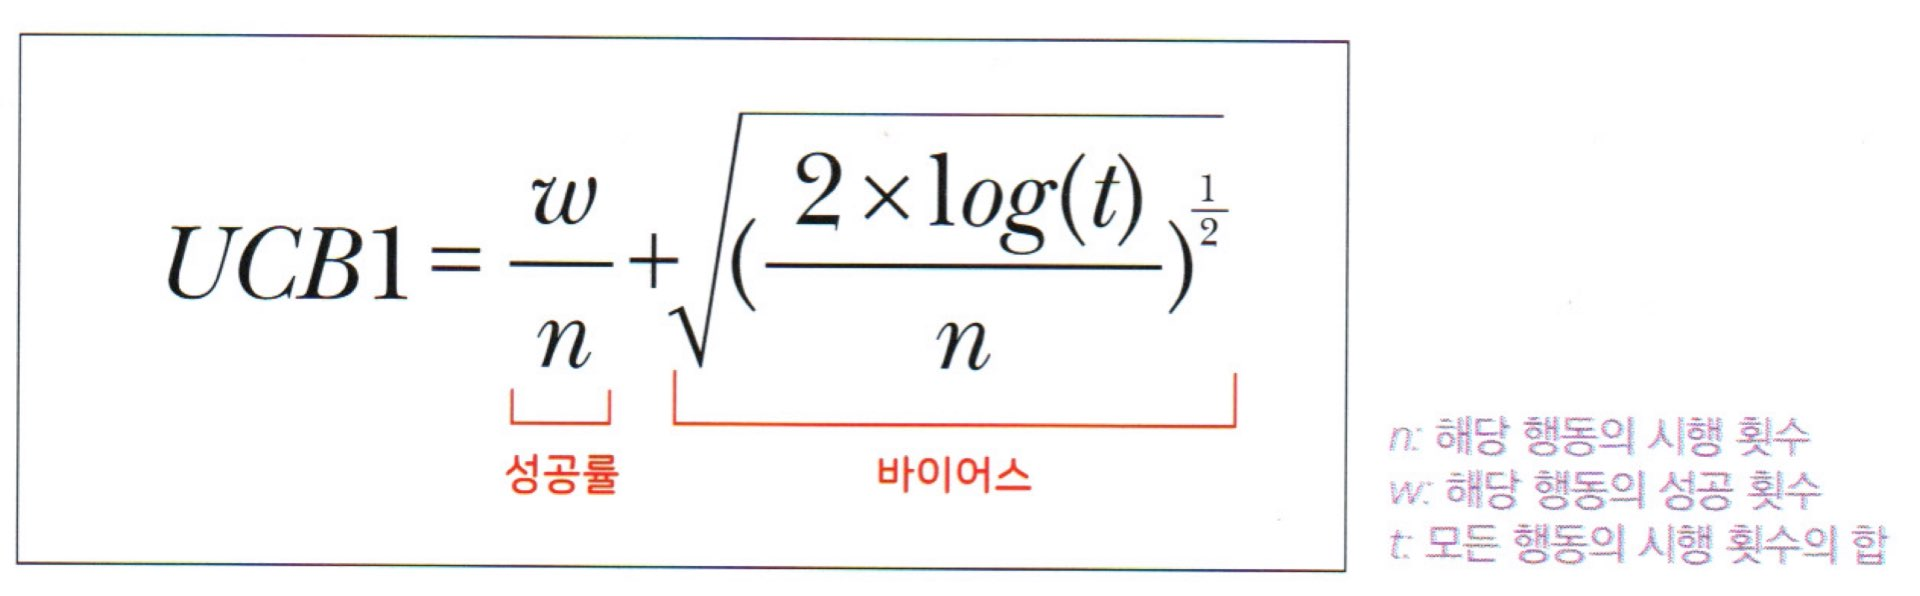

In [ ]:
Image('/content/drive/My Drive/2020_AI_Busan/4_DeepLearning/pic_rl/UCB1.jpeg')

# 성공률 + 편향값을 부여하여 가치를 갱신
# 식에 근거하면 시행 횟수가 0인 팔이 존재하면 -> 식 자체가 성립 불가 -> 모든 팔을 최소 한 번씩 사용한 후에 가치 갱신 계산을 시도하겠다
# 앱실론 -> 가치 갱신 => 팔을 하나 선택하면 팔 1개에 대해서 갱신을 수행
# UCB1   -> 가치 갱신 => 팔을 하나 선택하면(모든 팔을 다 선택한 이후) 팔 1개에 대해서 갱신을 수행한다
#                        -> 고민, 다른 팔의 가치에는 영향을 안 미치는가? 
#                        -> 식에서 t(모든 행동의 시행 횟수의 합 : 모든 팔의 시행 횟수)를 사용한다
#                        -> 팔을 하나 내리면, t가 변경되므로, 모든 팔의 가치도 다 변경된다
#                        -> 모든 팔에 대해서 가치 갱신을 수행한다

In [ ]:
2**0.5, np.sqrt(2)

(1.4142135623730951, 1.4142135623730951)

In [ ]:
class UCB1Engine(GameEngine):
  # def __init__(self ) : pass
  def initalize(self, cnt_arms):  
    self.n = np.zeros( cnt_arms ) # 각 팔의 시행 횟수
    self.v = np.zeros( cnt_arms ) # 각 팔의 가치(갱신된다)
    self.w = np.zeros( cnt_arms ) # 각 팔의 성공 횟수(팔을 당겼더니 보상1.0을 받았다)
    pass  
  def pull_arm(self):
    # 1. 모든 팔을 최소 1회 이상 선택을 해야 가치가 높은 팔을 선택하게 된다
    # 모든 팔을 체크 -> 선택하지 않은 팔이 존재하면 리턴
    for i in range( len(self.n) ): # 첫번째 팔부터 체크(개선 방안, 체크를 앞에서부터가 아닌 셔플)
      if not self.n[ i ]: # 한번도 선택되지 않은 팔
        return i
    # 2. 가치가 높은 팔 선택
    return np.argmax( self.v ) 
    pass  
  # 모든 팔이 최소 1회 선택이 되었다 -> 탐색을 모두 마쳤다
  def update_value(self, choice_arm, reward):
    # 해당 팔을 선택하는 횟수 증가
    self.n[ choice_arm ] += 1
    # 보상이 존재하면 
    if reward:  # if reward == 1.0:
      self.w[ choice_arm ] += 1
    # 팔 선택이 다 되지 않았다면 종료
    # 동일 환경의 시뮬레이터에서 각각의 알고리즘을 구동하다 보니, 호출될 상황이 아닌데 호출이 된다
    for i in range( len(self.n) ): # 첫번째 팔부터 체크(개선 방안, 체크를 앞에서부터가 아닌 셔플)
      if not self.n[ i ]: # 한번도 선택되지 않은 팔
        return # 가치 갱신을 하지 않는다
    # 가치 갱신
    for i in range( len(self.v) ): # 모든 팔의 가치를 하니씩 꺼내서
      # 1. 성공률 = w/n = (개별 팔의 성공횟수) / (개별 팔의 시행횟수)
      success_rate = self.w[i] / self.n[i]
      # 2. 바이어스
      t = self.n.sum()
      bias = ( ( 2*math.log(t) ) / self.n[i] )**0.5
      # 3. 개별가치를 갱신
      self.v[i] = success_rate + bias     
    
  def get_algo_name(self):  
    return 'UCB1 알고리즘'
  pass

# GameSimulator

- 게임을 설계한 자가 시뮬레이터 돌리는데 팔을 몇 개 만들지, 확률은 어떻게 줄지 설계
- 에이전트는 그것을 여러 번의 제한된 시도 내에서 팔을 선택하여 최대 보상을 얻을 수 있게 행동을 강화한다

In [ ]:
def play( algo, arms, sim_cnt, epi_cnt ):
  # 총 시도 횟수 = sim_cnt * epi_cnt
  times   = np.zeros( sim_cnt * epi_cnt )
  rewards = np.zeros( sim_cnt * epi_cnt )
  # 시뮬레이션 가동
  for sim in range(sim_cnt): # 0 ~ 999
    # 시뮬레이션 1회 -> 에피소드 250회 -> 게임엔진 알고리즘을 초기화 -> 250회동안 학습
    algo.initalize( len(arms) )
    for step in range(epi_cnt): # step 0~249
      # 게임 플레이
      # 1. 메타정보 - 시도 횟수를 기록한 위치 계산
      # 기록할 시작 위치
      offset          = epi_cnt * sim 
      index           = offset + step # 250*0+0~249, 250*1+0~249, 250*2+0~249
      # 2. 메타정보 - 시도 횟수 세팅
      times[ index ]  = step + 1    # 1회차, 2회차, 3회차, ... [1, 2, ..., 250, 1, 2, .., 250, 1, 2, ..., 250, ...]
      # 3. 본게임 - Arm 선택(당긴다)
      choice_arm      = algo.pull_arm()
      # 4. 본게임 - Arm 당김으로써 얻어지는 가치 획득 (1.0 or 0.0)
      reward          = arms[ choice_arm ].reward()
      # 5. 메타정보 - 보상 기록(보상 여부)       
      rewards[ index ]= reward
      # 6. 본게임 - 가치 업데이트 -> 팔의 가치를 계산, 내가 얻는 보상은 실제로 받은 1.0의 누적량
      algo.update_value( choice_arm, reward )
      pass
  
  return times, rewards

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50508 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51608 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50508 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44256 missing from current font.
  font.set_te

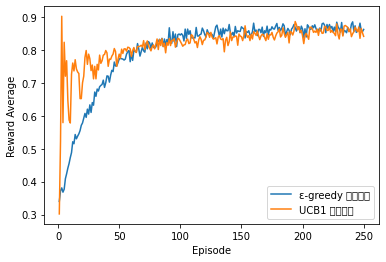

In [ ]:
# 게임 구성
arms  = [ SlotArm(0.3), SlotArm(0.5),  SlotArm(0.9) ]
algos = [ EpsilonGreedyEngine(), UCB1Engine() ]

# 시뮬레이션 횟수
SIMULATION_COUNT = 1000
# 게임 종료 횟수 -> 에피소드 횟수
EPISODE_COUNT    = 250

for algo in algos:
  # 알고리즘별로 시뮬레이션 1000회, 시뮬레이션 당 에피소드 250회를 수행
  times, rewards = play( algo, arms, SIMULATION_COUNT, EPISODE_COUNT) # 시뮬레이션
  # play()의 결과로 시행 횟수, 보상 등 정보를 받아서 -> 시각화, 로그 -> 상황에 따라서는 데이터가 된다   
  # times, rewards => 시각화
  df             = pd.DataFrame( { 'times':times, 'rewards':rewards } )
  # times를 중심으로 평균 표현
  # 1000번 시뮬레이션의 각 회차별 평균
  tmp            = df.groupby('times').mean()
  # x축 인덱스는 회차 : 1~250, y축 or 값 : reward의 평균(각 회차별 평균)
  # df의 shape ( 10000*250, 2 )
  plt.plot( tmp, label=algo.get_algo_name())

plt.xlabel('Episode')
plt.ylabel('Reward Average')
plt.legend( loc='best' )
plt.show()

- 결과
  -  초기에는 UCB1이 성능이 좋다 -> 탐색 비율을 높인 케이스
  - 중기이후에는 미세하게 앱실론이 우세 => 이용 비율을 높인 케이스

In [ ]:
df.tail(100)

,times,rewards
249900,151.0,1.0
249901,152.0,1.0
249902,153.0,1.0
249903,154.0,0.0
249904,155.0,0.0
...,...,...
249995,246.0,1.0
249996,247.0,1.0
249997,248.0,1.0
249998,249.0,1.0
